In [4]:
# Cell 1: Setup and Model Loading
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, average_precision_score, 
    classification_report, confusion_matrix,
    roc_curve, precision_recall_curve
)
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import data modules
from src.data.dataset import ChestXrayDataset, create_data_splits
from src.data.dataloader import create_rtx3060_dataloaders

print("✅ All imports successful")

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")

✅ All imports successful
🚀 Using device: cuda


In [12]:
# Cell 2: Define Model Architecture
class DenseNet121MultiLabel(nn.Module):
    """CLARITy DenseNet121 Multi-Label Classifier"""
    def __init__(self, num_classes=15, pretrained=True, dropout_rate=0.3):
        super().__init__()
        self.backbone = models.densenet121(pretrained=pretrained)
        num_features = self.backbone.classifier.in_features
        
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)
    
    def predict_probabilities(self, x):
        logits = self.forward(x)
        return torch.sigmoid(logits)

print("✅ Model architecture defined")

✅ Model architecture defined


In [13]:
# Cell 3: Load Your Trained Model
# Update this path to your actual saved model
MODEL_PATH = "../models/saved_models/densenet121.pth"  # Update this!

def load_clarity_model(model_path, device='cuda'):
    """Load CLARITy model from checkpoint"""
    print(f"📥 Loading model from: {model_path}")
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Create model
    model = DenseNet121MultiLabel(
        num_classes=checkpoint['num_classes'],
        pretrained=False,
        dropout_rate=checkpoint['dropout_rate']
    )
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print("✅ Model loaded successfully!")
    print(f"   Model: {checkpoint.get('model_name', 'CLARITy_DenseNet121')}")
    print(f"   Best AUC: {checkpoint['best_val_auc']:.3f}")
    print(f"   Epochs: {checkpoint['total_epochs']}")
    print(f"   Image Size: {checkpoint['image_size']}")
    
    return model, checkpoint

# Load your trained model
try:
    model, model_info = load_clarity_model(MODEL_PATH, device)
    print("🎉 Model ready for evaluation!")
except FileNotFoundError:
    print("❌ Model file not found!")
    print("Please update MODEL_PATH with your actual saved model filename")
    print("Check ../models/saved_models/ directory for available models")

📥 Loading model from: ../models/saved_models/densenet121.pth
✅ Model loaded successfully!
   Model: CLARITy_DenseNet121
   Best AUC: 0.691
   Epochs: 20
   Image Size: 384
🎉 Model ready for evaluation!


In [14]:
# Cell 4: Load Test Data (Same as Training Setup)
# Dataset path - UPDATE THIS
BASE_PATH = Path(r"D:/Projects/CLARITY/Model/Dataset/archive")  # Update this!

print("🔄 Loading dataset...")

# Load metadata
data_entry_path = BASE_PATH / "Data_Entry_2017.csv"
df = pd.read_csv(data_entry_path)
print(f"✅ Metadata loaded: {len(df):,} entries")

# Recreate image mapping
image_mapping = {}
for main_folder in sorted(BASE_PATH.iterdir()):
    if main_folder.is_dir() and main_folder.name.startswith('images_'):
        images_subfolder = main_folder / 'images'
        if images_subfolder.exists():
            for img_file in images_subfolder.glob("*.png"):
                image_name = img_file.name
                if image_name not in image_mapping:
                    image_mapping[image_name] = img_file

print(f"✅ Image mapping: {len(image_mapping):,} images")

# Create data splits (same random seed for consistency)
train_df, val_df, test_df = create_data_splits(df, 
                                               test_size=0.15,
                                               val_size=0.10,
                                               random_seed=42)

print(f"✅ Data splits: Train({len(train_df):,}) Val({len(val_df):,}) Test({len(test_df):,})")

🔄 Loading dataset...
✅ Metadata loaded: 112,120 entries
✅ Image mapping: 112,120 images
Patient-level data splits:
  Train: 83,847 images from 23,105 patients (74.8%)
  Val:   11,550 images from 3,080 patients (10.3%)
  Test:  16,723 images from 4,620 patients (14.9%)
✅ No patient overlap verified - clean splits!
✅ Data splits: Train(83,847) Val(11,550) Test(16,723)


In [15]:
# Cell 5: Create Test Dataset
# Get image size from model info (or default to 384)
image_size = model_info.get('image_size', 384)

test_dataset = ChestXrayDataset(
    df=test_df,
    image_mapping=image_mapping,
    image_size=image_size,
    is_training=False  # No augmentation for testing
)

# Create test dataloader
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"✅ Test dataset created:")
print(f"   Images: {len(test_dataset):,}")
print(f"   Batches: {len(test_loader):,}")
print(f"   Image size: {image_size}×{image_size}")

# Disease classes
disease_classes = [
    'No Finding', 'Atelectasis', 'Cardiomegaly', 'Effusion', 
    'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
    'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 
    'Pleural_Thickening', 'Hernia'
]

Dataset created with 16723 samples
Training mode: False
Image size: 384x384

Label matrix created: (16723, 15)
Positive samples per class:
  No Finding...............   9018
  Atelectasis..............   1691
  Cardiomegaly.............    426
  Effusion.................   1935
  Infiltration.............   2941
  Mass.....................    835
  Nodule...................    930
  Pneumonia................    220
  Pneumothorax.............    810
  Consolidation............    692
  Edema....................    333
  Emphysema................    417
  Fibrosis.................    281
  Pleural_Thickening.......    497
  Hernia...................     43
Transforms created for validation
✅ Test dataset created:
   Images: 16,723
   Batches: 1,046
   Image size: 384×384


In [16]:
# Cell 6: Comprehensive Model Evaluation
print("🧪 Running comprehensive model evaluation...")
print("=" * 60)

model.eval()
all_predictions = []
all_labels = []
all_logits = []
batch_times = []

# Run inference on test set
with torch.no_grad():
    for batch_idx, (images, labels, metadata) in enumerate(tqdm(test_loader, desc="Evaluating")):
        # Move to device
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        # Forward pass
        start_time = torch.cuda.Event(enable_timing=True)
        end_time = torch.cuda.Event(enable_timing=True)
        
        start_time.record()
        logits = model(images)
        probabilities = torch.sigmoid(logits)
        end_time.record()
        
        # Wait for GPU operations to complete
        torch.cuda.synchronize()
        batch_time = start_time.elapsed_time(end_time)
        batch_times.append(batch_time)
        
        # Store results
        all_predictions.append(probabilities.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_logits.append(logits.cpu().numpy())
        
        # Memory cleanup
        if batch_idx % 100 == 0:
            torch.cuda.empty_cache()

# Concatenate all results
predictions = np.concatenate(all_predictions, axis=0)
labels = np.concatenate(all_labels, axis=0)
logits = np.concatenate(all_logits, axis=0)

print(f"✅ Evaluation complete!")
print(f"   Test samples: {len(predictions):,}")
print(f"   Average batch time: {np.mean(batch_times):.2f} ms")
print(f"   Inference speed: {len(predictions) / (sum(batch_times)/1000):.1f} images/sec")

🧪 Running comprehensive model evaluation...


Evaluating: 100%|██████████████████████████████████████████████████████████████████| 1046/1046 [01:45<00:00,  9.94it/s]

✅ Evaluation complete!
   Test samples: 16,723
   Average batch time: 84.96 ms
   Inference speed: 188.2 images/sec


In [17]:
# Cell 7: Calculate All Performance Metrics
print("📊 Calculating comprehensive metrics...")

# Per-class metrics
class_aucs = []
class_aps = []  # Average Precision
class_stats = []

print(f"\n{'Disease Class':<25} {'AUC':<8} {'AP':<8} {'Pos Samples':<12} {'Prevalence':<10}")
print("-" * 70)

for i, disease in enumerate(disease_classes):
    # Get labels and predictions for this class
    y_true = labels[:, i]
    y_pred = predictions[:, i]
    
    n_positive = y_true.sum()
    n_total = len(y_true)
    prevalence = n_positive / n_total
    
    # Calculate metrics only if positive samples exist
    if n_positive > 0:
        auc = roc_auc_score(y_true, y_pred)
        ap = average_precision_score(y_true, y_pred)
    else:
        auc = np.nan
        ap = np.nan
    
    class_aucs.append(auc)
    class_aps.append(ap)
    class_stats.append({
        'disease': disease,
        'auc': auc,
        'ap': ap,
        'n_positive': n_positive,
        'n_total': n_total,
        'prevalence': prevalence
    })
    
    # Print results
    auc_str = f"{auc:.3f}" if not np.isnan(auc) else "N/A"
    ap_str = f"{ap:.3f}" if not np.isnan(ap) else "N/A"
    print(f"{disease:<25} {auc_str:<8} {ap_str:<8} {n_positive:<12.0f} {prevalence:<10.3f}")

# Overall metrics
valid_aucs = [auc for auc in class_aucs if not np.isnan(auc)]
valid_aps = [ap for ap in class_aps if not np.isnan(ap)]

mean_auc = np.mean(valid_aucs)
mean_ap = np.mean(valid_aps)

print("-" * 70)
print(f"{'OVERALL PERFORMANCE':<25} {mean_auc:<8.3f} {mean_ap:<8.3f}")
print("=" * 70)

# Model performance summary
print(f"\n🎯 CLARITy Model Test Results:")
print(f"   Mean AUC: {mean_auc:.3f}")
print(f"   Mean Average Precision: {mean_ap:.3f}")
print(f"   Classes evaluated: {len(valid_aucs)}/15")
print(f"   Test samples: {len(predictions):,}")

📊 Calculating comprehensive metrics...

Disease Class             AUC      AP       Pos Samples  Prevalence
----------------------------------------------------------------------
No Finding                0.670    0.687    9018         0.539     
Atelectasis               0.695    0.197    1691         0.101     
Cardiomegaly              0.789    0.137    426          0.025     
Effusion                  0.762    0.283    1935         0.116     
Infiltration              0.633    0.276    2941         0.176     
Mass                      0.605    0.079    835          0.050     
Nodule                    0.564    0.064    930          0.056     
Pneumonia                 0.645    0.023    220          0.013     
Pneumothorax              0.699    0.118    810          0.048     
Consolidation             0.736    0.103    692          0.041     
Edema                     0.828    0.078    333          0.020     
Emphysema                 0.648    0.040    417          0.025     
Fibro

📈 Creating performance visualizations...
💾 Evaluation plot saved: ..\results\densenet121_test_evaluation.png


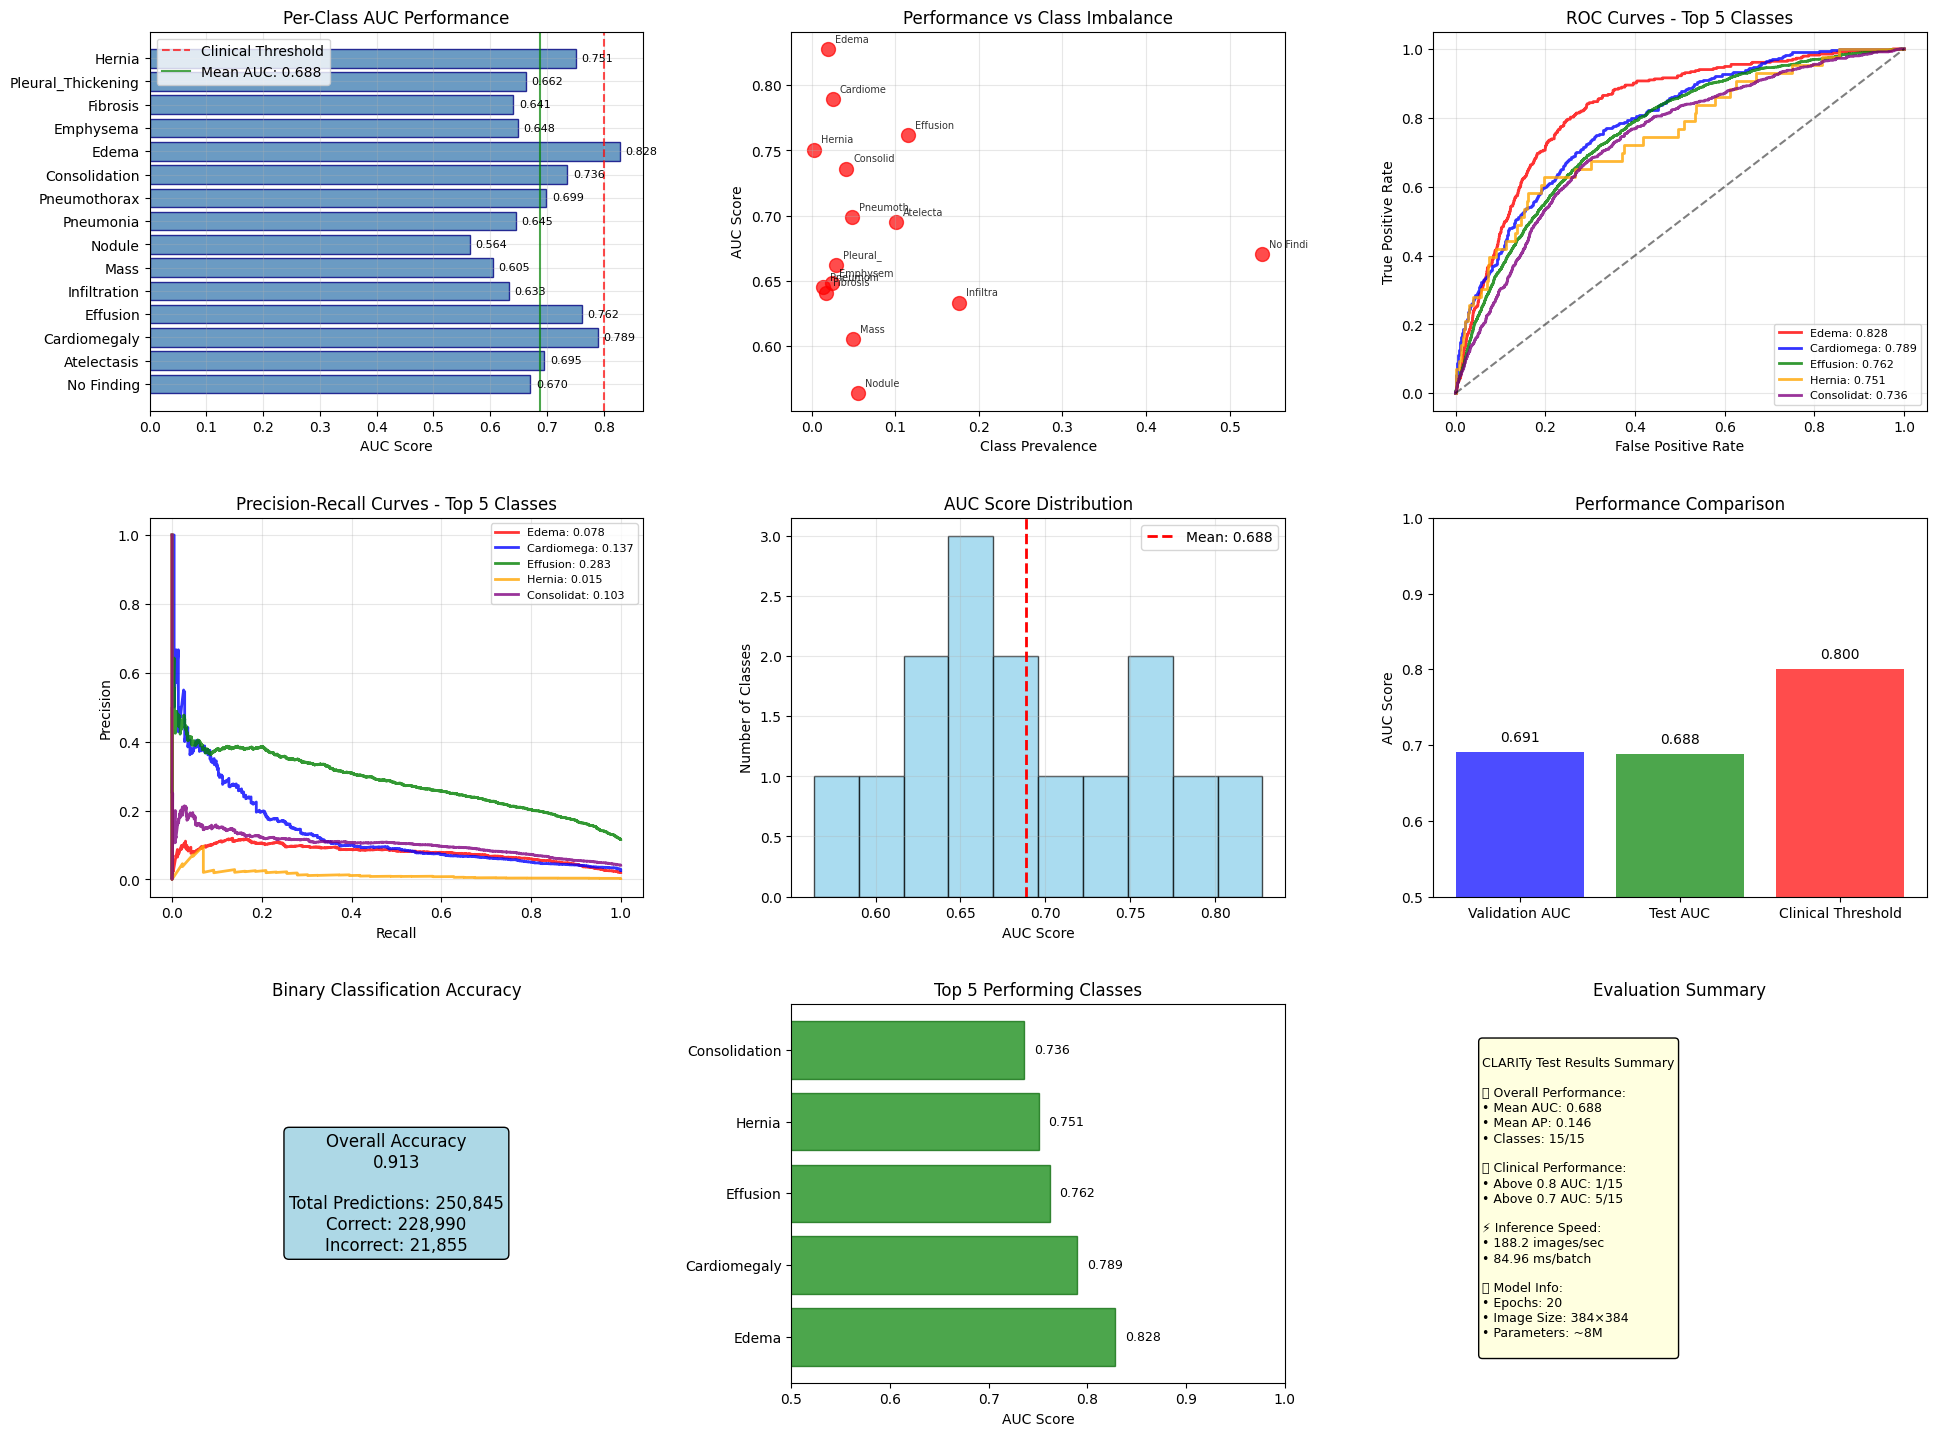

In [19]:
# Cell 8: Create Performance Visualizations
print("📈 Creating performance visualizations...")

# Set up plotting
plt.style.use('default')
fig = plt.figure(figsize=(20, 15))

# 1. Per-class AUC Bar Plot
ax1 = plt.subplot(3, 3, 1)
valid_diseases = [disease for disease, auc in zip(disease_classes, class_aucs) if not np.isnan(auc)]
valid_auc_values = [auc for auc in class_aucs if not np.isnan(auc)]

bars = plt.barh(range(len(valid_diseases)), valid_auc_values, 
                color='steelblue', alpha=0.8, edgecolor='navy')
plt.yticks(range(len(valid_diseases)), valid_diseases)
plt.xlabel('AUC Score')
plt.title('Per-Class AUC Performance')
plt.axvline(x=0.8, color='red', linestyle='--', alpha=0.7, label='Clinical Threshold')
plt.axvline(x=mean_auc, color='green', linestyle='-', alpha=0.7, label=f'Mean AUC: {mean_auc:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, valid_auc_values)):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center', fontsize=8)

# 2. Class Imbalance vs Performance
ax2 = plt.subplot(3, 3, 2)
prevalences = [stat['prevalence'] for stat in class_stats if not np.isnan(stat['auc'])]
valid_aucs_plot = [stat['auc'] for stat in class_stats if not np.isnan(stat['auc'])]

plt.scatter(prevalences, valid_aucs_plot, c='red', alpha=0.7, s=100)
plt.xlabel('Class Prevalence')
plt.ylabel('AUC Score')
plt.title('Performance vs Class Imbalance')
plt.grid(True, alpha=0.3)

# Add disease labels
for stat in class_stats:
    if not np.isnan(stat['auc']):
        plt.annotate(stat['disease'][:8], 
                    (stat['prevalence'], stat['auc']), 
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=7, alpha=0.8)

# 3. ROC Curves for Top 5 Classes
ax3 = plt.subplot(3, 3, 3)
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Get top 5 classes by AUC
top_classes = sorted([(auc, i, disease) for i, (auc, disease) in enumerate(zip(class_aucs, disease_classes)) 
                     if not np.isnan(auc)], reverse=True)[:5]

for color, (auc_val, class_idx, disease) in zip(colors, top_classes):
    y_true = labels[:, class_idx]
    y_pred = predictions[:, class_idx]
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, color=color, linewidth=2, 
             label=f'{disease[:10]}: {auc_val:.3f}', alpha=0.8)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Top 5 Classes')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)

# 4. Precision-Recall Curves
ax4 = plt.subplot(3, 3, 4)
for color, (auc_val, class_idx, disease) in zip(colors, top_classes):
    y_true = labels[:, class_idx]
    y_pred = predictions[:, class_idx]
    
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred)
    plt.plot(recall, precision, color=color, linewidth=2,
             label=f'{disease[:10]}: {ap:.3f}', alpha=0.8)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Top 5 Classes')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)

# 5. Performance Distribution
ax5 = plt.subplot(3, 3, 5)
plt.hist(valid_aucs, bins=10, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(mean_auc, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_auc:.3f}')
plt.xlabel('AUC Score')
plt.ylabel('Number of Classes')
plt.title('AUC Score Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Model Comparison (if you have validation results)
ax6 = plt.subplot(3, 3, 6)
if 'best_val_auc' in model_info:
    comparison_data = {
        'Validation AUC': model_info['best_val_auc'],
        'Test AUC': mean_auc,
        'Clinical Threshold': 0.80
    }
    
    bars = plt.bar(comparison_data.keys(), comparison_data.values(), 
                   color=['blue', 'green', 'red'], alpha=0.7)
    plt.ylabel('AUC Score')
    plt.title('Performance Comparison')
    plt.ylim(0.5, 1.0)
    
    for bar, value in zip(bars, comparison_data.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

# 7. Confusion Matrix Heatmap (Binary: Above/Below threshold)
ax7 = plt.subplot(3, 3, 7)
# Convert to binary predictions using 0.5 threshold
binary_preds = (predictions > 0.5).astype(int)
binary_labels = labels.astype(int)

# Calculate overall accuracy metrics
total_correct = (binary_preds == binary_labels).sum()
total_possible = binary_labels.size
accuracy = total_correct / total_possible

ax7.text(0.5, 0.5, f'Overall Accuracy\n{accuracy:.3f}\n\n'
                   f'Total Predictions: {total_possible:,}\n'
                   f'Correct: {total_correct:,}\n'
                   f'Incorrect: {total_possible - total_correct:,}',
         ha='center', va='center', transform=ax7.transAxes,
         fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
ax7.set_title('Binary Classification Accuracy')
ax7.axis('off')

# 8. Top Performing Classes
ax8 = plt.subplot(3, 3, 8)
top_5_diseases = [disease for _, _, disease in top_classes]
top_5_aucs = [auc_val for auc_val, _, _ in top_classes]

plt.barh(range(len(top_5_diseases)), top_5_aucs, 
         color='green', alpha=0.7, edgecolor='darkgreen')
plt.yticks(range(len(top_5_diseases)), top_5_diseases)
plt.xlabel('AUC Score')
plt.title('Top 5 Performing Classes')
plt.xlim(0.5, 1.0)

for i, (bar, value) in enumerate(zip(plt.gca().patches, top_5_aucs)):
    plt.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{value:.3f}', va='center', fontsize=9)

# 9. Summary Statistics
ax9 = plt.subplot(3, 3, 9)
summary_text = f"""
CLARITy Test Results Summary

📊 Overall Performance:
• Mean AUC: {mean_auc:.3f}
• Mean AP: {mean_ap:.3f}
• Classes: {len(valid_aucs)}/15

🏥 Clinical Performance:
• Above 0.8 AUC: {sum(1 for auc in valid_aucs if auc >= 0.8)}/15
• Above 0.7 AUC: {sum(1 for auc in valid_aucs if auc >= 0.7)}/15

⚡ Inference Speed:
• {len(predictions) / (sum(batch_times)/1000):.1f} images/sec
• {np.mean(batch_times):.2f} ms/batch

💾 Model Info:
• Epochs: {model_info.get('total_epochs', 'N/A')}
• Image Size: {image_size}×{image_size}
• Parameters: ~8M
"""

ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes, fontsize=9,
         verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))
ax9.set_title('Evaluation Summary')
ax9.axis('off')

plt.tight_layout(pad=3.0)

# Save the comprehensive plot
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_dir = Path("../results")
results_dir.mkdir(parents=True, exist_ok=True)

plot_path = results_dir / f"densenet121_test_evaluation.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"💾 Evaluation plot saved: {plot_path}")

plt.show()

📊 Creating all confusion matrices in one image...
✅ All confusion matrices saved in one image:
   📁 File: ..\results\densenet121_confusion_matrices.png
   📏 Size: 0.7 MB


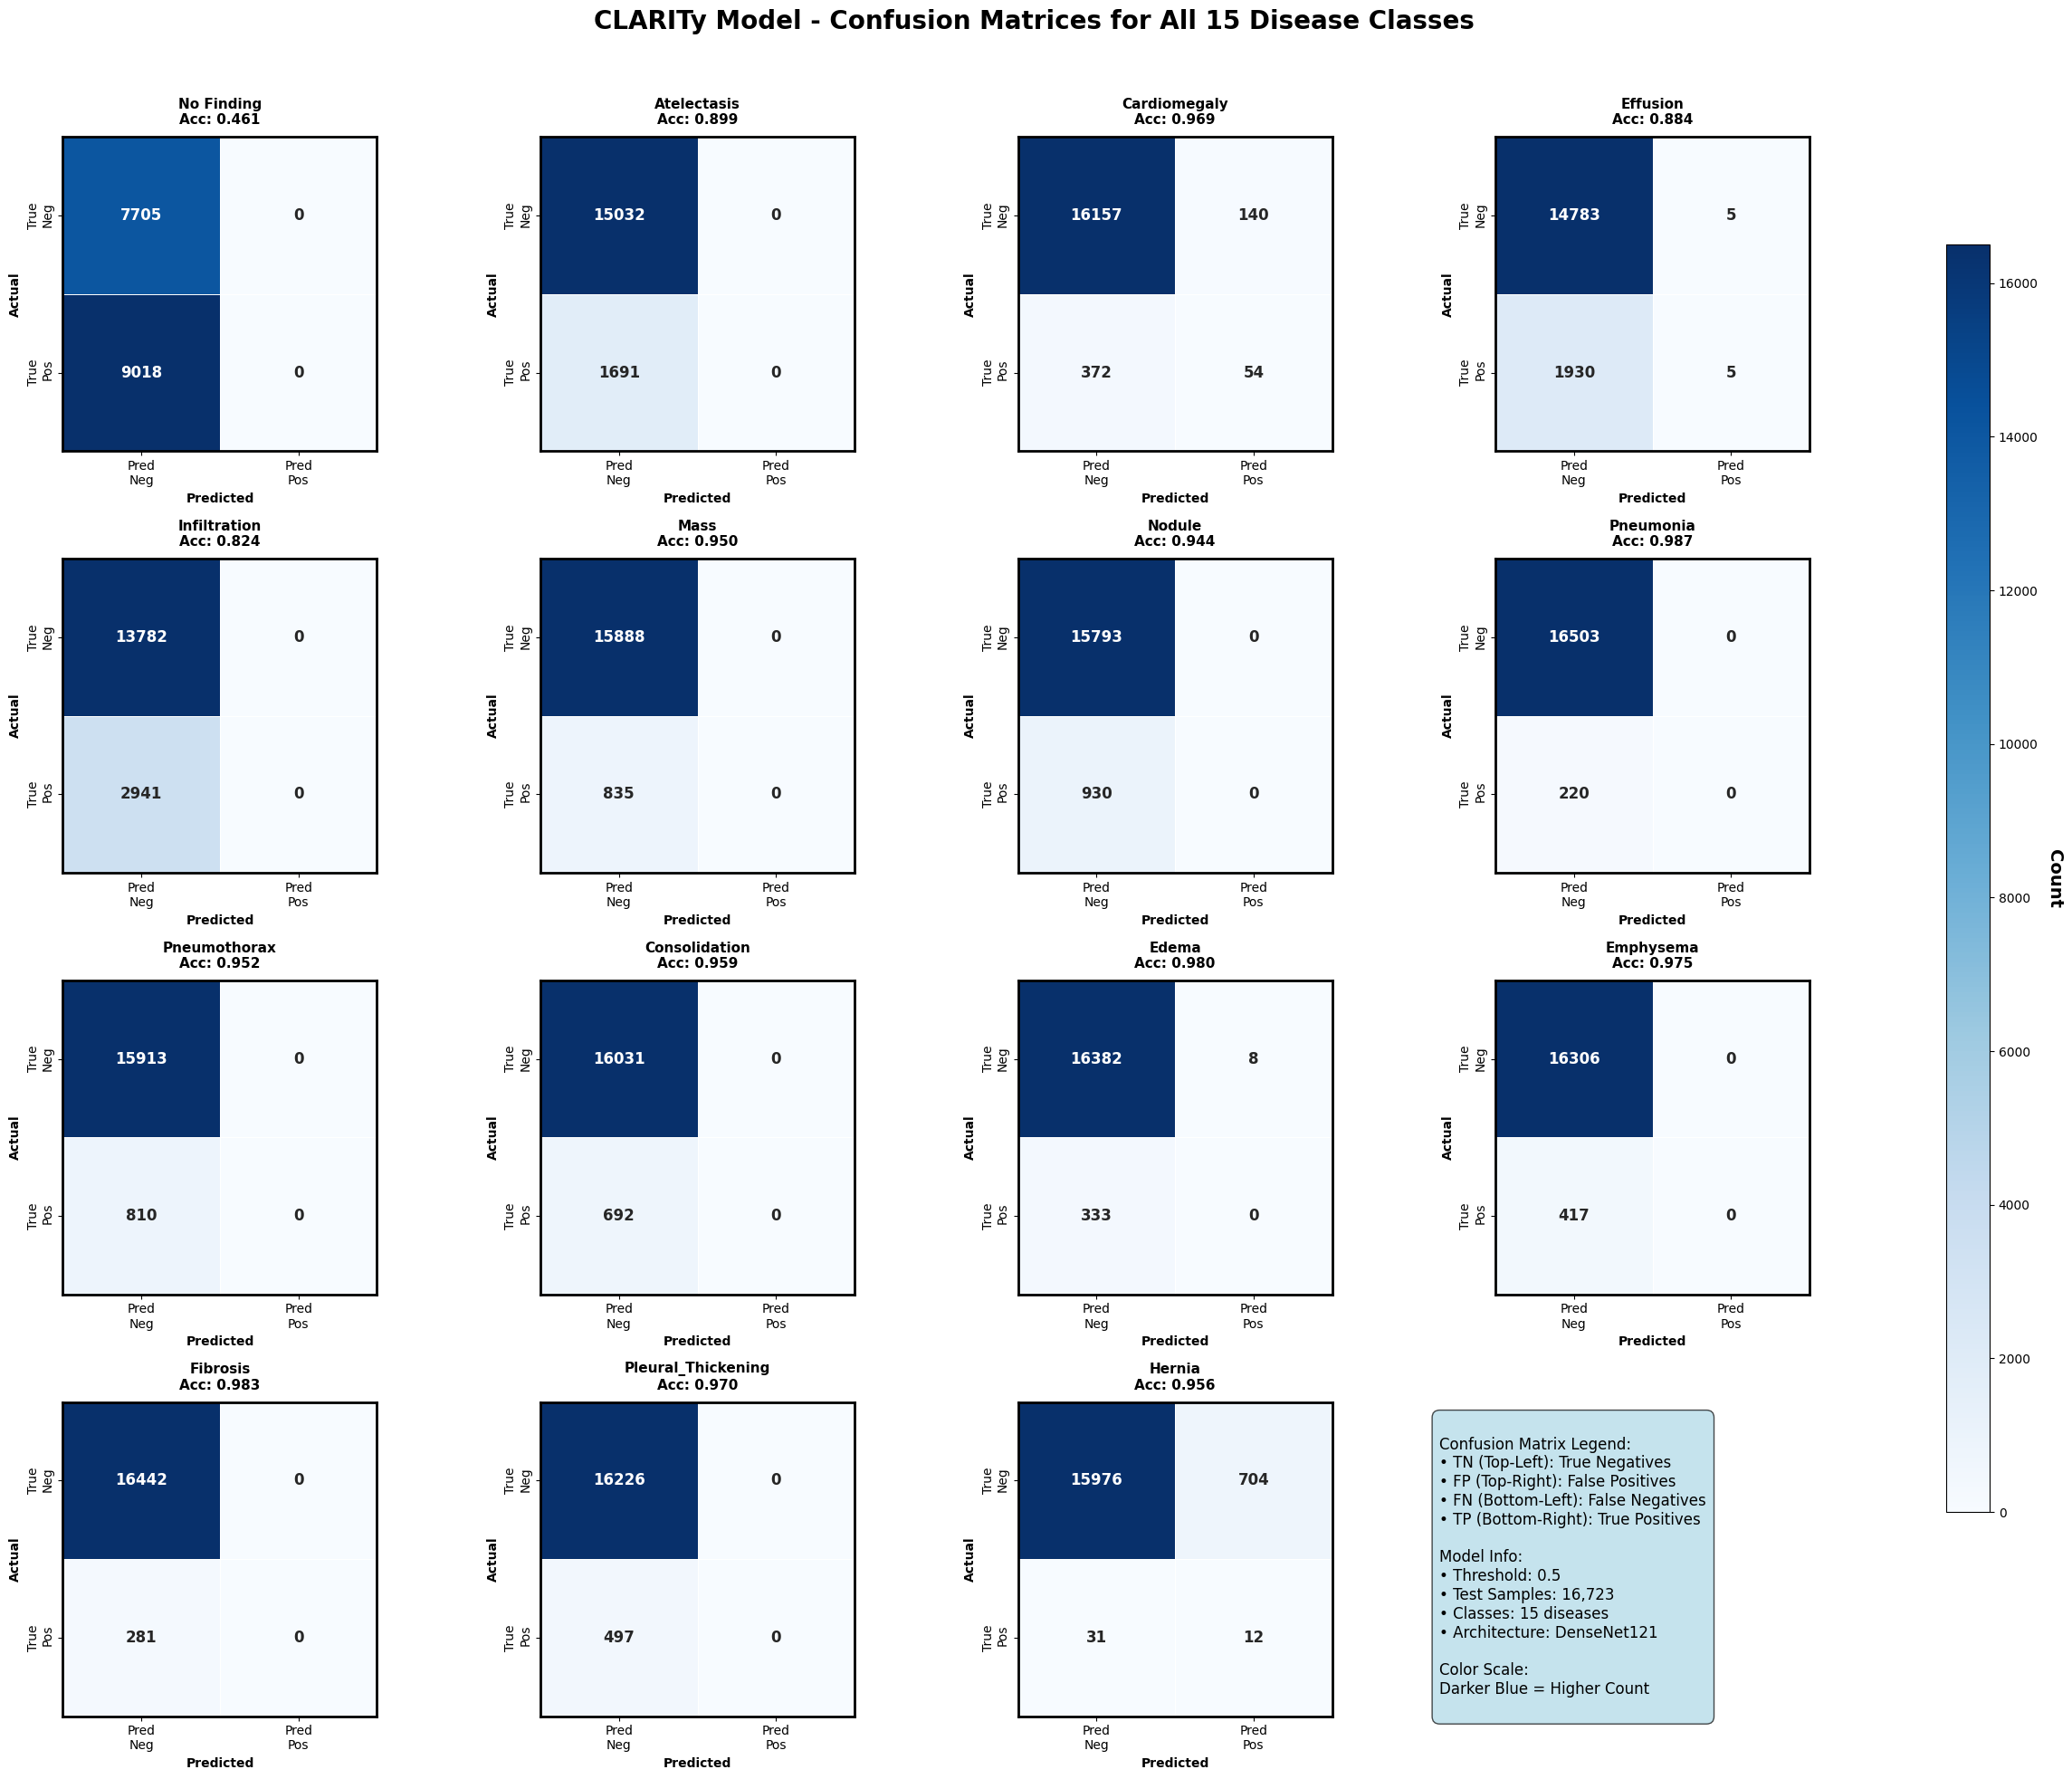

In [24]:
# All Confusion Matrices in One Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from pathlib import Path
from datetime import datetime

# Create results directory
results_dir = Path("../results")
results_dir.mkdir(parents=True, exist_ok=True)

# Set threshold and get binary predictions
threshold = 0.5
binary_predictions = (predictions >= threshold).astype(int)

# Disease classes
disease_classes = [
    'No Finding', 'Atelectasis', 'Cardiomegaly', 'Effusion', 
    'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
    'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 
    'Pleural_Thickening', 'Hernia'
]

print("📊 Creating all confusion matrices in one image...")

# Create large figure with 4x4 grid (15 matrices + 1 legend)
fig, axes = plt.subplots(4, 4, figsize=(24, 20))
fig.suptitle('CLARITy Model - Confusion Matrices for All 15 Disease Classes', 
             fontsize=20, y=0.98, fontweight='bold')

# Color scheme
cmap = 'Blues'

for idx, disease in enumerate(disease_classes):
    row = idx // 4
    col = idx % 4
    ax = axes[row, col]
    
    # Get confusion matrix
    y_true = labels[:, idx]
    y_pred = binary_predictions[:, idx]
    cm = confusion_matrix(y_true, y_pred)
    
    # Handle edge cases where only one class exists
    if cm.shape == (1, 1):
        if y_true.sum() == 0:  # All negatives
            cm = np.array([[cm[0,0], 0], [0, 0]])
        else:  # All positives  
            cm = np.array([[0, 0], [0, cm[0,0]]])
    elif cm.shape == (2, 1):  # Only negatives predicted
        cm = np.array([[cm[0,0], cm[1,0]], [0, 0]])
    elif cm.shape == (1, 2):  # Only positives predicted
        cm = np.array([[cm[0,0], 0], [cm[0,1], 0]])
    
    # Plot heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax,
                xticklabels=['Pred\nNeg', 'Pred\nPos'], 
                yticklabels=['True\nNeg', 'True\nPos'],
                cbar=False, square=True, linewidths=0.5,
                annot_kws={'fontsize': 12, 'fontweight': 'bold'})
    
    # Calculate metrics for subtitle
    tn, fp, fn, tp = cm.ravel()
    total = tp + tn + fp + fn
    accuracy = (tp + tn) / total if total > 0 else 0
    
    # Set title with disease name and accuracy
    ax.set_title(f'{disease}\nAcc: {accuracy:.3f}', 
                fontsize=11, fontweight='bold', pad=10)
    
    # Style the plot
    ax.set_xlabel('Predicted', fontsize=10, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=10, fontweight='bold')
    
    # Add border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_edgecolor('black')

# Use the last subplot for legend/summary
ax_legend = axes[3, 3]
ax_legend.axis('off')

# Create summary text
summary_text = f"""
Confusion Matrix Legend:
• TN (Top-Left): True Negatives
• FP (Top-Right): False Positives  
• FN (Bottom-Left): False Negatives
• TP (Bottom-Right): True Positives

Model Info:
• Threshold: {threshold}
• Test Samples: {len(labels):,}
• Classes: 15 diseases
• Architecture: DenseNet121

Color Scale:
Darker Blue = Higher Count
"""

ax_legend.text(0.05, 0.95, summary_text, transform=ax_legend.transAxes, 
               fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.7))

# Add a color bar manually
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Find max value across all confusion matrices for consistent color scaling
max_val = 0
for idx in range(15):
    y_true = labels[:, idx]
    y_pred = binary_predictions[:, idx]
    cm = confusion_matrix(y_true, y_pred)
    max_val = max(max_val, cm.max())

# Create colorbar
norm = Normalize(vmin=0, vmax=max_val)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

# Add colorbar to the figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Count', rotation=270, labelpad=20, fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 0.96])

# Save the comprehensive confusion matrix image
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f"densenet121_confusion_matrices.png"
filepath = results_dir / filename

plt.savefig(filepath, dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')

print(f"✅ All confusion matrices saved in one image:")
print(f"   📁 File: {filepath}")
print(f"   📏 Size: {filepath.stat().st_size / (1024*1024):.1f} MB")

plt.show()